**Note**:
- I am leaving out code to plot loss curves on tensorboard, because this didn't seem necessary for this exercise.
- While working on a notebook might not be suitable for big projects, I thought for this exercise, it gives a nice way to look through all the code in a concise manner.
- I am using higher learning rate than what is ideal, but it helps with the speed.
- I just used a small subset of flickr30K dataset to show how to learn the Sobel kernel. 

In [1]:
import os
import cv2
import datasets
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

from datasets import load_dataset
from functools import partial
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

from utils import visualize, process_image_with_custom_kernel, convolve_with_kernel, process_image
from models import SobelFilter, SobelFilterEfficient, GeneralFilter

/srv/flash1/hagrawal9/anaconda3/envs/poly/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
SEED = 0
#set all seed
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)
#set seed for cuda
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


In [4]:
DATA_DIR = '/srv/flash1/hagrawal9/project/img2img/data/flickr30k'
CHECKPOINT_DIR = 'checkpoints'

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)

CACHE_DIR_SOBEL = os.path.join(DATA_DIR, 'sobel')
CACHE_DIR_CUSTOM_KERNEL = os.path.join(DATA_DIR, 'sobel')
DATASET_SIZE = 1000
BATCH_SIZE = 100

# Do you want to learn both the filters together in the kernel? 
LEARN_BOTH_FILERS = False

## A. Preparing the data

In [5]:
dataset = load_dataset("nlphuji/flickr30k", data_dir=DATA_DIR, cache_dir=DATA_DIR)

Using custom data configuration default-54e08063d402c3e7
Found cached dataset flickr30k (/srv/flash1/hagrawal9/project/img2img/data/flickr30k/nlphuji___flickr30k/default-54e08063d402c3e7/1.1.0/6adb9ab2367c57c3e81e76ecaecb8047ea00c33dccf9da10455037f32ec43382)
100%|██████████| 1/1 [00:00<00:00, 355.75it/s]


In [6]:
dataset_test = dataset['test'].select(np.arange(0, 1000).tolist())

In [7]:
dataset_test_sobel = dataset_test.map(process_image, remove_columns=['split', 'caption', 'sentids', 'filename', 'img_id', 'image'])

Loading cached processed dataset at /srv/flash1/hagrawal9/project/img2img/data/flickr30k/nlphuji___flickr30k/default-54e08063d402c3e7/1.1.0/6adb9ab2367c57c3e81e76ecaecb8047ea00c33dccf9da10455037f32ec43382/cache-5f03f9960af60e5a.arrow


In [8]:
dataset_test_sobel.save_to_disk(CACHE_DIR_SOBEL)

## B. Learning the Sobel kernel

In [9]:
dataset_test_sobel = datasets.load_from_disk(CACHE_DIR_SOBEL)
dataset_test_sobel.set_format(type='torch')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


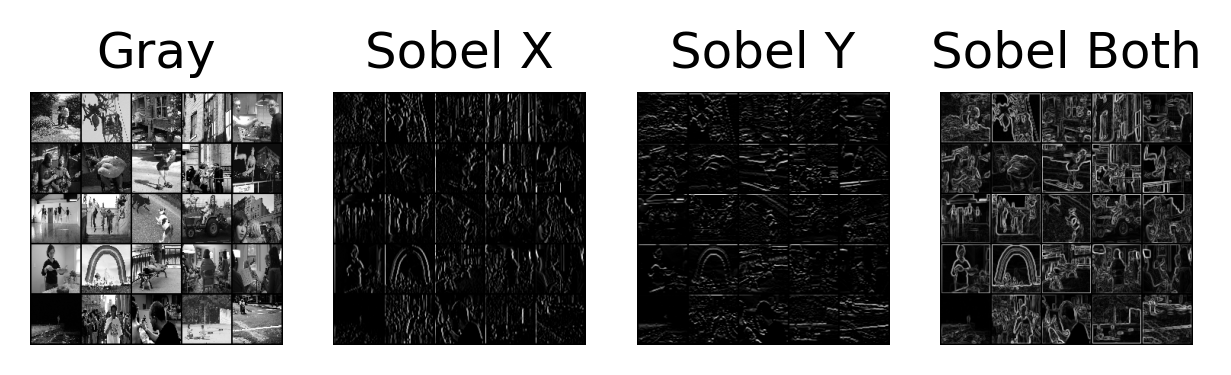

In [10]:
visualize({'Gray': dataset_test_sobel['image_np'][:25].to(torch.int16), 'Sobel X': dataset_test_sobel['sb_img_x'][:25].to(torch.int16), 'Sobel Y': dataset_test_sobel['sb_img_y'][:25].to(torch.int16), 'Sobel Both': dataset_test_sobel['sb_img'][:25].to(torch.int16)})

In [11]:
dataloader = DataLoader(dataset_test_sobel, batch_size=100, shuffle=True, num_workers=10)

In [12]:
def train(conv_layer, dataloader, target_key, ckpt_name, kernel_size=(3, 3), lr=0.0001, weight_decay=0.1, momentum=0.9, epochs=1000):
    """ Train the network to obtain the kernel for the filter. 
    Args:
        conv_layer: The network to obtain the output. 
        dataloader: Dataloader for fetching the data.
        ckpt_name: Save the model with this name.
        target_key: Key corresponding to the target in the data dict.
        kernel_size: Size of the learned kernel. 
        lr: Learning rate. 
        weight_decay: Optimizer parameter. Good values are 0.1, 0.01
        momentum: Optimizer parameter. 
        epochs: maximum epochs to train on. 
    """
    
    l1 = nn.L1Loss(reduction='mean').to('cuda')
    optimizer = optimizer = optim.SGD(conv_layer.parameters(), 
                                      lr=lr, weight_decay=weight_decay, momentum=momentum)
    
    # for early stopping
    best_loss = 10000
    patience = 15
    delta = 0.01
    counter = 0
    early_stop = False
 
    for i in range(epochs):
        total_diff = 0
        for data in dataloader:
            t1 = time.time()
            optimizer.zero_grad()
            output = conv_layer(data['image_np'].cuda())
            loss = l1(output, data[target_key].cuda())
            loss.backward()
            optimizer.step()
            total_diff += time.time() - t1

        if loss < best_loss - delta:
            best_loss = loss
            counter = 0
            # save the model
            torch.save(conv_layer.state_dict(), f'{CHECKPOINT_DIR}/{ckpt_name}.best.pt')

        elif counter > patience:
            # Stop because loss isn't improving.
            print(f'\nEarly stopping after no improvement in {patience} epochs. Best loss: {best_loss:.4f}')
            break

        counter += 1

        print(f'Epoch: {i:3d}, Time/Epoch: {total_diff:.4f}, Loss: {loss.item():4.4f}')

### B.1 Learning the horizontal Sobel Filter.

In [13]:
model = SobelFilter(1, False).to('cuda')
train(model, dataloader, target_key='sb_img_x', ckpt_name='sobel_filter_x', kernel_size=(3,3), epochs = 100)

Epoch:   0, Time/Epoch: 3.4561, Loss: 97.3118
Epoch:   1, Time/Epoch: 0.0346, Loss: 91.6979
Epoch:   2, Time/Epoch: 0.0387, Loss: 87.2400
Epoch:   3, Time/Epoch: 0.0375, Loss: 75.4122
Epoch:   4, Time/Epoch: 0.0421, Loss: 67.6954
Epoch:   5, Time/Epoch: 0.0462, Loss: 53.0166
Epoch:   6, Time/Epoch: 0.0355, Loss: 47.7183
Epoch:   7, Time/Epoch: 0.0472, Loss: 37.0336
Epoch:   8, Time/Epoch: 0.0408, Loss: 27.5657
Epoch:   9, Time/Epoch: 0.0373, Loss: 19.1540
Epoch:  10, Time/Epoch: 0.0323, Loss: 11.8776
Epoch:  11, Time/Epoch: 0.0392, Loss: 6.6840
Epoch:  12, Time/Epoch: 0.0480, Loss: 5.0715
Epoch:  13, Time/Epoch: 0.0376, Loss: 3.1243
Epoch:  14, Time/Epoch: 0.0353, Loss: 2.8993
Epoch:  15, Time/Epoch: 0.0452, Loss: 2.7787
Epoch:  16, Time/Epoch: 0.0508, Loss: 3.2093
Epoch:  17, Time/Epoch: 0.0477, Loss: 4.7894
Epoch:  18, Time/Epoch: 0.0455, Loss: 19.7834
Epoch:  19, Time/Epoch: 0.0366, Loss: 11.4587
Epoch:  20, Time/Epoch: 0.0415, Loss: 2.3900
Epoch:  21, Time/Epoch: 0.0399, Loss: 1.64

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[[ 0.9948, -0.0047, -1.0036],
          [ 1.9911, -0.0049, -2.0008],
          [ 0.9947, -0.0047, -1.0034]]]], device='cuda:0',
       grad_fn=<FlipBackward0>)


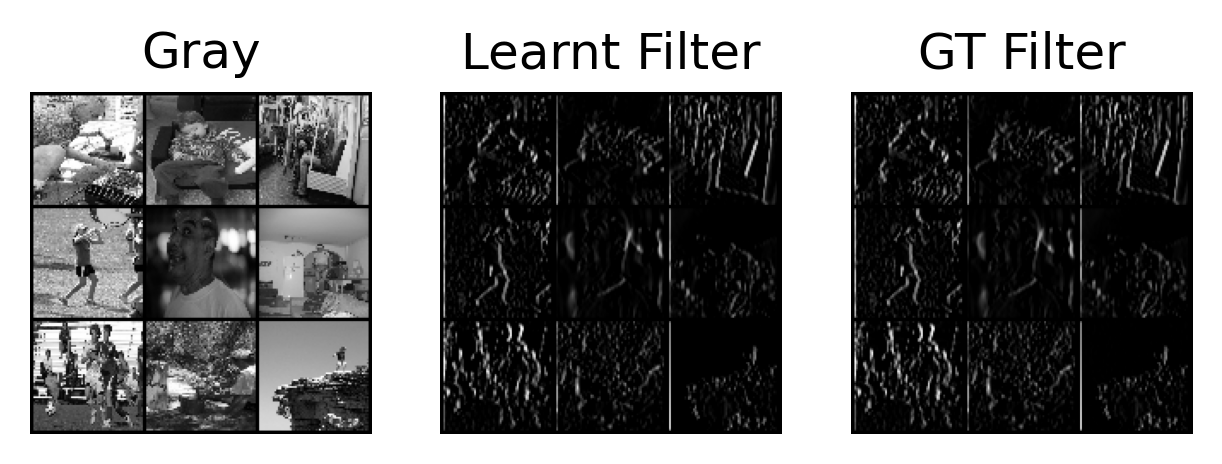

In [14]:
# visualize w/ GT horizontal sobel filter.
model = SobelFilter(1, False).to('cuda')
model.load_state_dict(torch.load(f'{CHECKPOINT_DIR}/sobel_filter_x.best.pt'))
model.eval()

kernel = torch.Tensor([
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1],
]).flip([0, 1]) # conv2d is cross-correlation, so flip the kernel.
data = next(iter(dataloader))

learned_kernel = torch.flip(model.conv_layer.weight, [2, 3]) # flip the learned kernel to see the correct output.
print(learned_kernel)

output = convolve_with_kernel(data['image_np'].to('cuda'), model.conv_layer.weight) # convolve with learned kernel
target = convolve_with_kernel(data['image_np'], kernel[None, None]) # convolve with GT kernel.

visualize({'Gray': data['image_np'][:9].to(torch.int16), 'Learnt Filter': output[:9].cpu(), 'GT Filter': target[:9].cpu()})


### B.2 Learning the double Sobel Filter together

In [16]:
c2_model = SobelFilter(2, True).to('cuda')
train(c2_model, dataloader, target_key='sb_img', ckpt_name='sobel_double_kernel', kernel_size=(3,3), epochs = 100)


Epoch:   0, Time/Epoch: 0.0375, Loss: 134.2488
Epoch:   1, Time/Epoch: 0.0510, Loss: 126.9548
Epoch:   2, Time/Epoch: 0.0445, Loss: 126.4177
Epoch:   3, Time/Epoch: 0.0426, Loss: 122.1465
Epoch:   4, Time/Epoch: 0.0454, Loss: 117.4751
Epoch:   5, Time/Epoch: 0.0459, Loss: 118.5798
Epoch:   6, Time/Epoch: 0.0622, Loss: 111.5185
Epoch:   7, Time/Epoch: 0.0466, Loss: 106.0063
Epoch:   8, Time/Epoch: 0.0402, Loss: 97.2637
Epoch:   9, Time/Epoch: 0.0447, Loss: 87.1168
Epoch:  10, Time/Epoch: 0.0507, Loss: 78.1968
Epoch:  11, Time/Epoch: 0.0396, Loss: 71.9829
Epoch:  12, Time/Epoch: 0.0524, Loss: 64.0044
Epoch:  13, Time/Epoch: 0.0455, Loss: 58.7506
Epoch:  14, Time/Epoch: 0.0425, Loss: 52.0611
Epoch:  15, Time/Epoch: 0.0463, Loss: 50.6479
Epoch:  16, Time/Epoch: 0.0480, Loss: 46.7123
Epoch:  17, Time/Epoch: 0.0575, Loss: 44.4167
Epoch:  18, Time/Epoch: 0.0524, Loss: 47.2192
Epoch:  19, Time/Epoch: 0.0454, Loss: 44.9079
Epoch:  20, Time/Epoch: 0.0480, Loss: 44.9118
Epoch:  21, Time/Epoch: 0.

tensor([[[[-7.6386e-01, -1.9473e+00, -1.1886e+00],
          [ 4.3581e-01, -7.4732e-04, -4.2633e-01],
          [ 1.1881e+00,  1.9662e+00,  7.5984e-01]]],


        [[[ 1.2002e+00,  4.2844e-01, -7.6156e-01],
          [ 1.9428e+00,  2.1012e-03, -1.9525e+00],
          [ 7.6470e-01, -4.3131e-01, -1.1920e+00]]]], device='cuda:0',
       grad_fn=<FlipBackward0>)


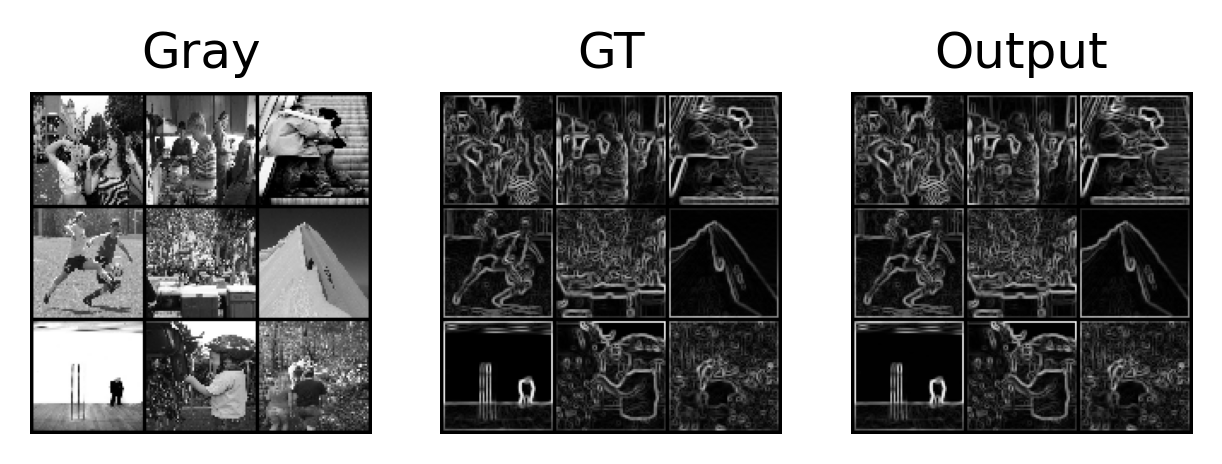

In [18]:
# visualize
c2_model = SobelFilter(2, True).to('cuda')
c2_model.load_state_dict(torch.load(f'{CHECKPOINT_DIR}/sobel_double_kernel.best.pt'))
c2_model.eval()

data = next(iter(dataloader))

learned_kernel = torch.flip(c2_model.conv_layer.weight, [2, 3])
print(learned_kernel)

output = convolve_with_kernel(data['image_np'].to('cuda'), learned_kernel)
output = torch.sqrt(
    torch.sum(torch.pow(output, 2), axis=1)
) # B, H, W
output = output.unsqueeze(1) # introduce a new axis, B x 1 x H x W

visualize({'Gray': data['image_np'][:9].to(torch.int16), 'GT': data['sb_img'][:9].to(torch.int16), 'Output': output[:9].cpu().to(torch.int16)})

### B.3 Learning the single Sobel filter using a small set of parameters (6).

In [12]:
c1_eff_model = SobelFilterEfficient(1, False).to('cuda')
train(c1_eff_model, dataloader, target_key='sb_img_x', ckpt_name='sobel_x_eff', kernel_size=(3,3), epochs = 100)

Epoch:   0, Time/Epoch: 0.1401, Loss: 107.5778
Epoch:   1, Time/Epoch: 0.0227, Loss: 128.2243
Epoch:   2, Time/Epoch: 0.0225, Loss: 107.2460
Epoch:   3, Time/Epoch: 0.0207, Loss: 87.6515
Epoch:   4, Time/Epoch: 0.0333, Loss: 74.6467
Epoch:   5, Time/Epoch: 0.0350, Loss: 52.3711
Epoch:   6, Time/Epoch: 0.0203, Loss: 25.7254
Epoch:   7, Time/Epoch: 0.0348, Loss: 24.8412
Epoch:   8, Time/Epoch: 0.0368, Loss: 18.4750
Epoch:   9, Time/Epoch: 0.0207, Loss: 14.9429
Epoch:  10, Time/Epoch: 0.0469, Loss: 19.3047
Epoch:  11, Time/Epoch: 0.0344, Loss: 14.9001
Epoch:  12, Time/Epoch: 0.0360, Loss: 18.0301
Epoch:  13, Time/Epoch: 0.0209, Loss: 16.7017
Epoch:  14, Time/Epoch: 0.0201, Loss: 9.0272
Epoch:  15, Time/Epoch: 0.0203, Loss: 15.3388
Epoch:  16, Time/Epoch: 0.0209, Loss: 15.4248
Epoch:  17, Time/Epoch: 0.0303, Loss: 16.4214
Epoch:  18, Time/Epoch: 0.0365, Loss: 7.6090
Epoch:  19, Time/Epoch: 0.0356, Loss: 36.9386
Epoch:  20, Time/Epoch: 0.0283, Loss: 30.8841
Epoch:  21, Time/Epoch: 0.0337, L

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[[-9.9641e-01, -3.9680e-04,  9.9498e-01],
          [-1.9964e+00, -7.9502e-04,  1.9935e+00],
          [-9.9661e-01, -3.9687e-04,  9.9517e-01]]]], device='cuda:0',
       grad_fn=<FlipBackward0>)
tensor([[-1.,  0.,  1.],
        [-2.,  0.,  2.],
        [-1.,  0.,  1.]])


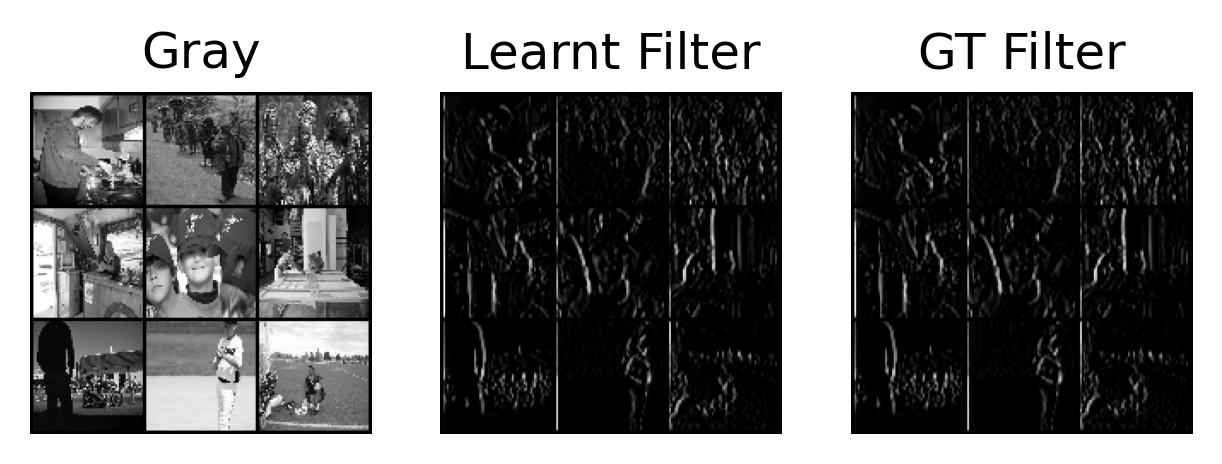

In [17]:
# visualize
c1_eff_model = SobelFilterEfficient(1, False).to('cuda')
c1_eff_model.load_state_dict(torch.load(f'{CHECKPOINT_DIR}/sobel_x_eff.best.pt'))
c1_eff_model.eval()

kernel = torch.Tensor([
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1],
]).flip([0, 1]) # conv2d is cross-correlation, so flip the kernel.

data = next(iter(dataloader))

learned_kernel = torch.flip(c1_eff_model.kernel, [2, 3])
print(learned_kernel)
print(kernel)

output = convolve_with_kernel(data['image_np'].to('cuda'), learned_kernel)
target = convolve_with_kernel(data['image_np'], kernel[None, None])

visualize({'Gray': data['image_np'][:9].to(torch.int16), 'Learnt Filter': output[:9].cpu().to(torch.int16), 'GT Filter': target[:9].cpu().to(torch.int16)})


### Questions

Q: What if the image is really large or not of a standard size?  
- Given my implementation, it doesn't matter. We have one convolution later, and a L1 loss at the end both of which are invariant to size of the image. 

Q: What should occur at the edges of the image?
- We padded the image at the beginning to keep the output resolution same as input. 

Q: Are you using a fully convolutional architecture?
- Yes. Our network doesn't have any dense fully-connected layers. 

Q: Are there optimizations built into your framework of choice (e.g. Pytorch) that can make this fast?
We implemented early-stopping, running on GPU. There's a bit scope of improvements in speed: 
- Use asynchronous data loading during training.
- Use an efficient data loader like ffcv (https://github.com/libffcv/ffcv)

Q: What if you wanted to optimize specifically for model size?
- The model currently has 9 parameters. :-) You can make this more efficient for the case of Sobel operator, by breaking down the kernel into vectors (U, V) \in R^3, and then building the kernel using kernel = U^T * V. This reduces the number of parameters from 9 to 6. 

How do you know when training is complete?
- In our case, we have implemented early stopping. So when the loss fails to reduce for a fixed number of steps, we stop the training. In our case, 

What is the benefit of a deeper model in this case? When might there be a benefit for a deeper model (not with a sobel kernel but generally when thinking about image to image transformations)?
For the sobel kernel, there is no benefit of a deeper model. We know how Sobel operators work, it's a 3x3 kernel that's convoluted with the image. We can use this domain expertise to design an efficient architecture. However, deeper models can benefit in a lot of situations: 
- One key area, where they might benefit from is image to image transformations which require understanding semantics in the image (RGB -> Depth, RGB -> Segmentation). In this cases, you want to understand how the pixels are getting transformed at various receptive field resolution. Early layers will be able to understand things like edges, while later layers can understand high level semantics such as object parts etc. [1]

[1] https://arxiv.org/abs/1412.6856



### Extra Credit -- Any kernel. 

In [19]:
# Create a custom kernel here (Gaussian Kernel)
# Register a function that uses the kernel.

custom_kernel = 1/256 * torch.Tensor([
    [1, 4, 6, 4, 1],
    [4, 16, 24, 16, 4],
    [6, 24, 36, 24, 6],
    [4, 16, 24, 16, 4],
    [1, 4, 6, 4, 1]
])[None, None]

process_image_with_kernel = partial(process_image_with_custom_kernel, custom_kernel)

In [20]:
dataset_test_kernel = dataset_test.map(process_image_with_kernel, remove_columns=['split', 'caption', 'sentids', 'filename', 'img_id', 'image'])

100%|██████████| 1000/1000 [00:13<00:00, 74.58ex/s]


In [21]:
dataset_test_kernel.save_to_disk(CACHE_DIR_CUSTOM_KERNEL)

In [22]:
dataset_test_kernel = datasets.load_from_disk(CACHE_DIR_CUSTOM_KERNEL)
dataset_test_kernel.set_format(type='torch')
dataloader_test_kernel = DataLoader(dataset_test_kernel, batch_size=100, shuffle=True, num_workers=10)

In [24]:
model = GeneralFilter(1, combine=False, kernel_size=5).to('cuda')
train(model, dataloader_test_kernel, target_key='output', ckpt_name='custom_kernel', kernel_size=(5,5), epochs = 50)

Epoch:   0, Time/Epoch: 0.0349, Loss: 18.3279
Epoch:   1, Time/Epoch: 0.0376, Loss: 28.6297
Epoch:   2, Time/Epoch: 0.0371, Loss: 27.1806
Epoch:   3, Time/Epoch: 0.0370, Loss: 21.9603
Epoch:   4, Time/Epoch: 0.0358, Loss: 29.0931
Epoch:   5, Time/Epoch: 0.0370, Loss: 19.0592
Epoch:   6, Time/Epoch: 0.0413, Loss: 31.1836
Epoch:   7, Time/Epoch: 0.0337, Loss: 17.8730
Epoch:   8, Time/Epoch: 0.0390, Loss: 7.1393
Epoch:   9, Time/Epoch: 0.0376, Loss: 33.8559
Epoch:  10, Time/Epoch: 0.0360, Loss: 41.3695
Epoch:  11, Time/Epoch: 0.0350, Loss: 67.3872
Epoch:  12, Time/Epoch: 0.0404, Loss: 46.7237
Epoch:  13, Time/Epoch: 0.0351, Loss: 1.6725
Epoch:  14, Time/Epoch: 0.0420, Loss: 39.3470
Epoch:  15, Time/Epoch: 0.0299, Loss: 51.9499
Epoch:  16, Time/Epoch: 0.0378, Loss: 4.8352
Epoch:  17, Time/Epoch: 0.0392, Loss: 47.7872
Epoch:  18, Time/Epoch: 0.0304, Loss: 8.8095
Epoch:  19, Time/Epoch: 0.0380, Loss: 72.5272
Epoch:  20, Time/Epoch: 0.0355, Loss: 39.5294
Epoch:  21, Time/Epoch: 0.0407, Loss: 

tensor([[[[0.0113, 0.0407, 0.0419, 0.0077, 0.0386],
          [0.0391, 0.0724, 0.1024, 0.1040, 0.0102],
          [0.0445, 0.0904, 0.1633, 0.1281, 0.0210],
          [0.0122, 0.1188, 0.0721, 0.0716, 0.0515],
          [0.0269, 0.0039, 0.0780, 0.0058, 0.0205]]]], device='cuda:0',
       grad_fn=<FlipBackward0>)


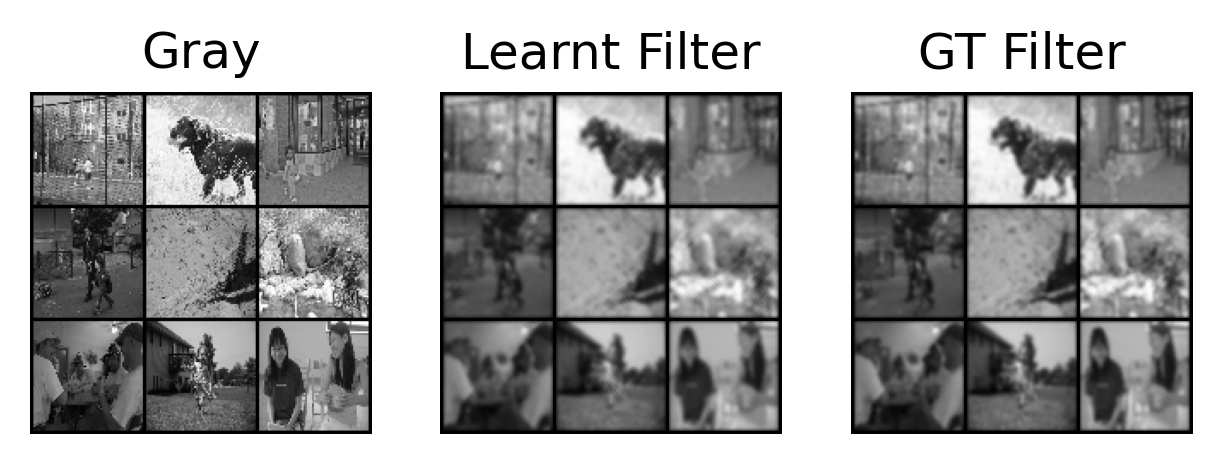

In [27]:
# visualize
model = GeneralFilter(1, combine=False, kernel_size=5).to('cuda')
model.load_state_dict(torch.load(f'{CHECKPOINT_DIR}/custom_kernel.best.pt'))
model.eval()

data = next(iter(dataloader_test_kernel))

learned_kernel = torch.flip(model.conv_layer.weight, [2, 3])
print(learned_kernel)

output = convolve_with_kernel(data['image_np'].to('cuda'),model.conv_layer.weight)
target = convolve_with_kernel(data['image_np'], torch.flip(custom_kernel, [2, 3]))

visualize({'Gray': data['image_np'][:9].to(torch.int16), 'Learnt Filter': output[:9].cpu().to(torch.int16), 'GT Filter': target[:9].cpu().to(torch.int16)})


Q: What are the limitations of this?
A: A few limitations that come to mind.
- This approach will only work for simple kernel based filters which convolve with the image once. Anything more sophisticated won't work.
- Consequently, this approach assumes prior information, the fact that the transformation was achieved by a single kernel based filter. Given no prior information, our approach has very little model capacity, and will most likely underfit to the data. 